In [119]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import *
from scipy.optimize import curve_fit
from scipy import integrate

path = "C:\\Users\\iammo\\Documents\\Optimising-Field-Synthesiser\\HCF sim\\Python\\Luna_BO\\tests\\optimise_with_FT_and_phase\\spectrum_data\\"
file = "1300nm_init.csv"
filepath = path + file

In [120]:
c=299792458

def get_phase(omega,Eomega, lambda0):
    #retrieves phase and subtracts the arbitrary phase at omega0
    om0 = 2*np.pi*c/lambda0 #central frequency
    om0_idx = np.argmin(np.abs(omega-om0))
 
    domega = omega[2] - omega[1]
    tau = np.pi/domega
    phase_raw = np.angle(Eomega)
    phase = np.unwrap(phase_raw - omega*tau)
    phase=phase*(-1)#optics convention
    phase -= phase[om0_idx]#subtract arbitrary phase offset
    return phase


In [121]:
def moment(x,y,n): 
    """
    returns an integral of the nth moment of intensity over frequency
    """
    integrand = np.array([]) #array of overlaps of the intensity with itself with a freq shift omega_shift
    for i in range(len(x)):
        integrand=np.append(integrand,y[i]*x[i]**n)
    return integrate.simps(integrand,x) 


In [122]:
import pandas as pd
df_0 = pd.read_csv(filepath,skipinitialspace=True)
omega=df_0.iloc[:,0]
Eomega_real=df_0.iloc[:,1]
Eomega_imag=df_0.iloc[:,2]

Eom = Eomega_real + 1j*Eomega_imag
om=[]
for i in omega:
    om.append(i)
om=np.array(om)

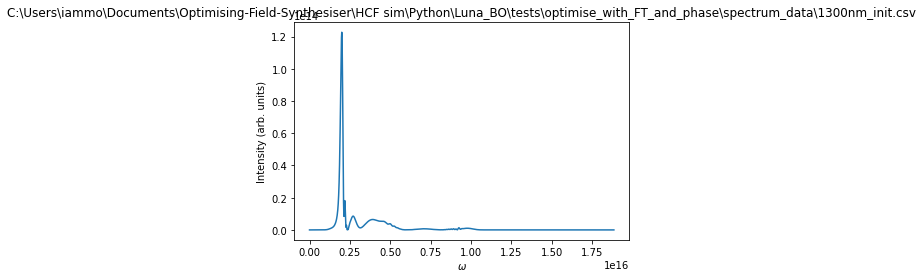

In [123]:
plt.plot(omega, np.abs(Eom)**2)
plt.title(filepath)
plt.xlabel(r"$\omega$")
plt.ylabel("Intensity (arb. units)")
plt.show()

In [124]:
# First get phase of pulse in freq domain
om0 = moment(om,np.abs(Eom)**2,1)/moment(om,np.abs(Eom)**2,0) # Determine central frequency
c=299792458
lambda0 = (2*np.pi*c)/om0
print(lambda0)
phase = get_phase(om, Eom, lambda0)

# Smooth electric field using super Gaussian filter
λ=(2*np.pi*c)/om



filter = []
for i in range(len(λ)):
    filter.append(np.exp(-((λ[i]-300e-9)/(300e-9*0.1))**4))

Eom_smooth = []
for i in range(len(Eom)):
    Eom_smooth.append(Eom[i]*filter[i])

6.51712390497446e-07


C:\Users\iammo\AppData\Local\Temp/ipykernel_38088/1263991804.py:9: RuntimeWarning: divide by zero encountered in true_divide
  λ=(2*np.pi*c)/om


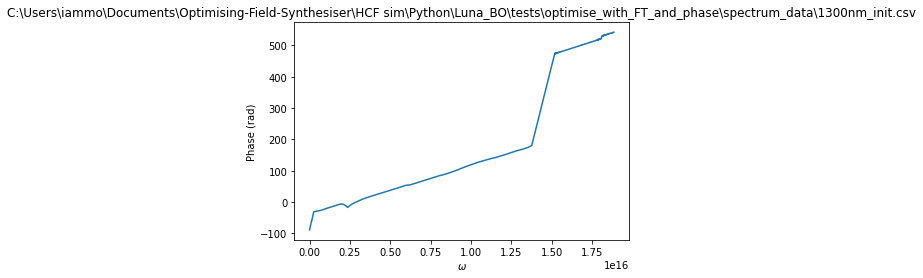

In [125]:
plt.plot(omega, phase)
plt.title(filepath)
plt.xlabel(r"$\omega$")
plt.ylabel("Phase (rad)")
plt.show()

In [126]:
# Slice phase to only select part within pulse
thresh = 0.1
rows = np.where(np.abs(Eom_smooth)**2 > max(np.abs(Eom_smooth)**2)*thresh)[0]
min_index = rows[0]
max_index = rows[-1]

phase_slice = phase[min_index-25:max_index+25]
om_slice = om[min_index-25:max_index+25]

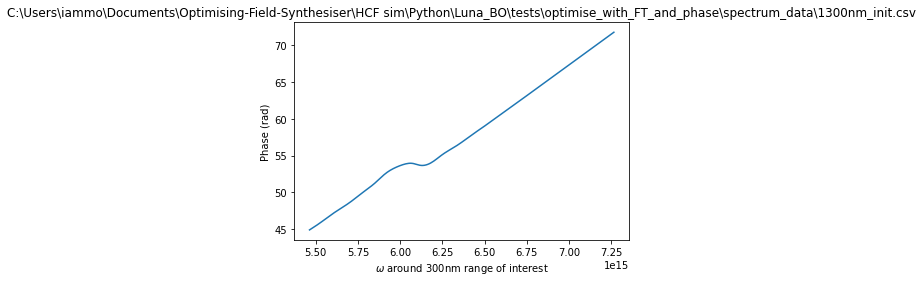

In [127]:
plt.plot(om_slice, phase_slice)
plt.title(filepath)
plt.xlabel(r"$\omega$ around 300nm range of interest")
plt.ylabel("Phase (rad)")
plt.show()

In [128]:
# Fit a quadratic to the phase and remove this
def quad(x, a, b, c):
    return a*(x**2) + b*x + c
quad_popt, _ = curve_fit(quad, om_slice, phase_slice, p0=[1,1,0])
phase_to_remove = quad(om_slice, *quad_popt)
new_phase = np.zeros(len(om))

for i in range(len(phase_to_remove)):
    new_phase[i+min_index-25] += phase_slice[i] - phase_to_remove[i]

# Add the phase back to the intensity profile
Eom_complex0 = [] # raw data
Eom_complex1 = [] # quad phase removed
Eom_complex2 = [] # phase zeroed
for i in range(len(om)):
    Eom_complex0.append(np.abs(Eom_smooth[i])*np.exp(-1j*phase[i]))
    Eom_complex1.append(np.abs(Eom_smooth[i])*np.exp(-1j*new_phase[i]))
    Eom_complex2.append(np.abs(Eom_smooth[i])*np.exp(-1j*0))

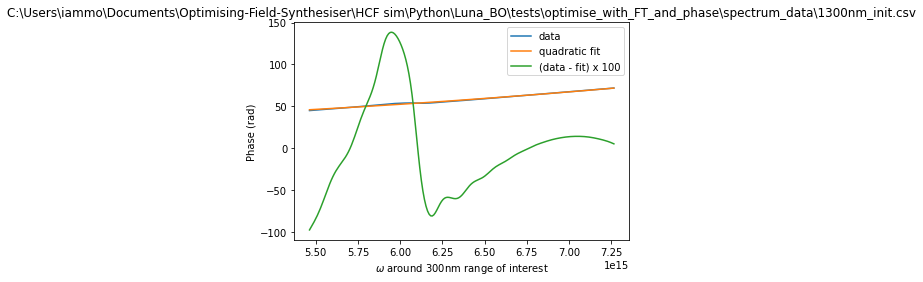

In [129]:
plt.plot(om_slice, phase_slice, label="data")
plt.plot(om_slice, phase_to_remove, label="quadratic fit")
plt.plot(om_slice, 100*(phase_slice - phase_to_remove), label="(data - fit) x 100")
plt.title(filepath)
plt.xlabel(r"$\omega$ around 300nm range of interest")
plt.ylabel("Phase (rad)")
plt.legend()
plt.show()

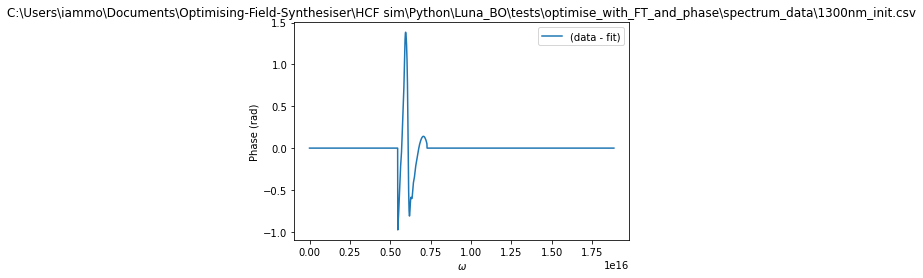

In [130]:
plt.plot(omega, new_phase, label="(data - fit)")
plt.title(filepath)
plt.xlabel(r"$\omega$")
plt.ylabel("Phase (rad)")
plt.legend()
plt.show()

In [131]:
def get_index(arr, v):
    return (np.abs(arr - v)).argmin()

In [132]:
i0 = get_index(omega, 0.5e16)
i1 = get_index(omega, 0.75e16)
print(i0, i1)

544 815


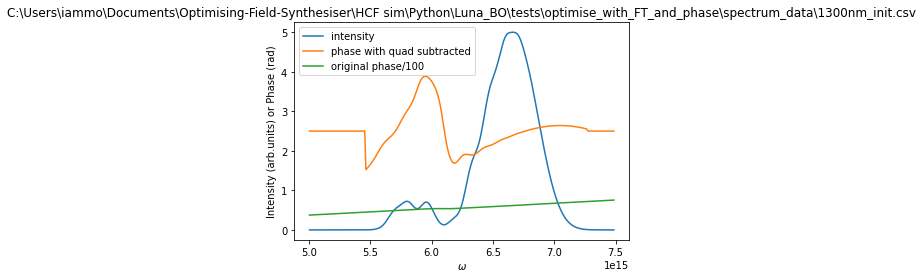

In [133]:
plt.plot(omega[i0:i1], 5*np.abs(Eom_complex0[i0:i1])**2/np.max(np.abs(Eom_complex0[i0:i1])**2), label="intensity")
plt.plot(omega[i0:i1], 2.5 +new_phase[i0:i1], label="phase with quad subtracted")
plt.plot(omega[i0:i1], phase[i0:i1]/100, label="original phase/100")
plt.title(filepath)
plt.xlabel(r"$\omega$")
plt.ylabel("Intensity (arb.units) or Phase (rad)")
plt.legend()
plt.show()

In [134]:
# Now Fourier transform
Et0 = np.fft.fftshift(np.fft.ifft(Eom_complex0))
f_step = (omega[1]-omega[0])/(2*np.pi)
t0 = np.fft.fftshift(np.fft.fftfreq(len(Eom_complex0), d=f_step))

Et1 = np.fft.fftshift(np.fft.ifft(Eom_complex1))
f_step = (omega[1]-omega[0])/(2*np.pi)
t1 = np.fft.fftshift(np.fft.fftfreq(len(Eom_complex1), d=f_step))

Et2 = np.fft.fftshift(np.fft.ifft(Eom_complex2))
f_step = (omega[1]-omega[0])/(2*np.pi)
t2 = np.fft.fftshift(np.fft.fftfreq(len(Eom_complex2), d=f_step))

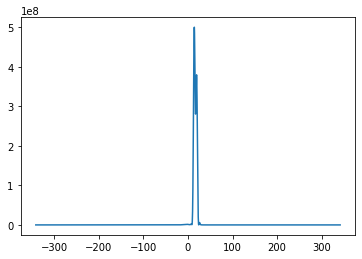

In [135]:
plt.plot(t0*1e15, np.abs(Et0)**2)
plt.show()

In [136]:
k0, k1 = get_index(t0, 0e-15), get_index(t0, 200e-15)
print(k0, k1)

1024 1624


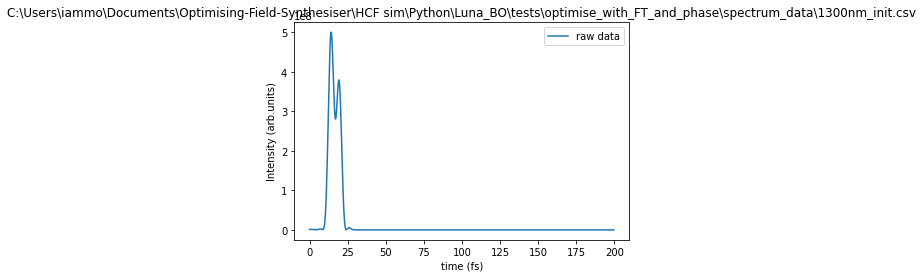

In [137]:
plt.plot(t0[k0:k1]*1e15, np.abs(Et0[k0:k1])**2, label="raw data")
plt.title(filepath)
plt.xlabel("time (fs)")
plt.ylabel("Intensity (arb.units)")
plt.legend()
plt.show()

In [138]:
j0, j1 = get_index(t0, -50e-15), get_index(t0, 50e-15)
print(j0, j1)

874 1174


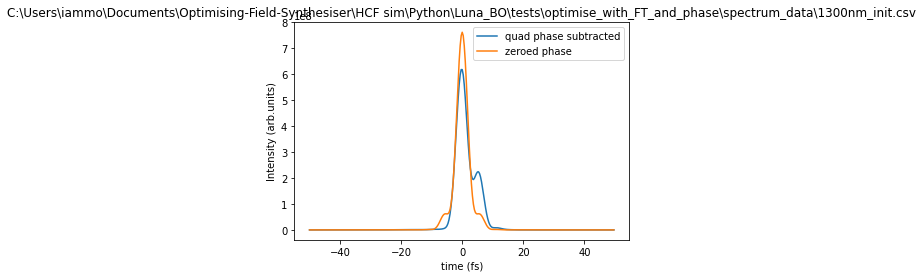

In [139]:
plt.plot(t1[j0:j1]*1e15, np.abs(Et1[j0:j1])**2, label="quad phase subtracted")
plt.plot(t2[j0:j1]*1e15, np.abs(Et2[j0:j1])**2, label="zeroed phase")
plt.title(filepath)
plt.xlabel("time (fs)")
plt.ylabel("Intensity (arb.units)")
plt.legend()
plt.show()

In [140]:
import sys
sys.path.append('C:\\Users\\iammo\\Documents\\Optimising-Field-Synthesiser\\HCF sim\\Python\\building_datasets\\')
from rms_width import *

print('Duration with quadratic phase subtracted = {}'.format(rms_width(t1[j0:j1]*1e15, np.abs(Et1[j0:j1])**2)))
print('Duration with zero phase = {}'.format(rms_width(t2[j0:j1]*1e15, np.abs(Et2[j0:j1])**2)))
print('Duration with of raw data = {}'.format(rms_width(t0[k0:k1]*1e15, np.abs(Et0[k0:k1])**2)))

Duration with quadratic phase subtracted = 6.947679473863987
Duration with zero phase = 5.648947127012172
Duration with of raw data = 6.22846652688354
